# Time Series Analysis

## 1) Data Loading and Visualization

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

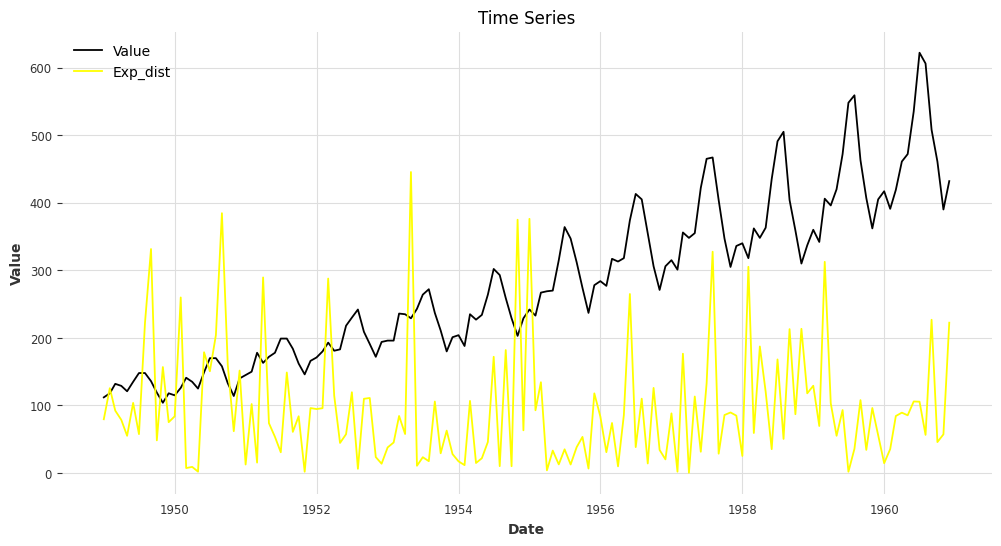

In [47]:
#Load and preprocess time series data
#series = pd.read_csv('data.csv', parse_dates=['date'], index_col='date')
series = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
#print(series)

#create a second stationary timeseries:
# Generate 144 random values from an exponential distribution
exp_values = np.random.exponential(scale=100, size=144)
# Create the DataFrame
date_index = series.index
series2 = pd.DataFrame({'exp': exp_values}, index=date_index)


def plot_time_series(series, series2, title="Time Series"):
    """
    Plot time series with proper formatting
    """
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Value')
    plt.plot(series2, label='Exp_dist', color = 'yellow')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_time_series(series, series2, title="Time Series")

## 2) Stationarity check

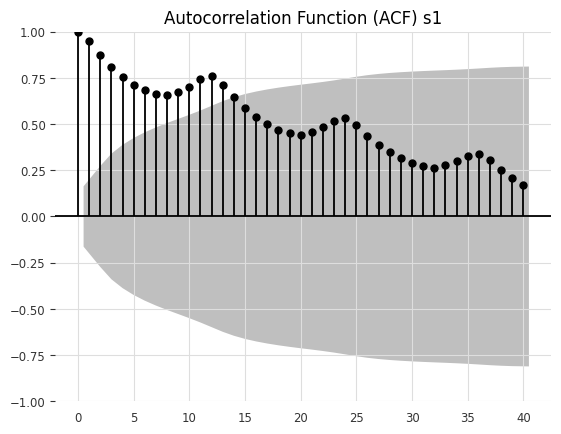

ADF Statistic: 0.8154
p-value: 0.9919
Non-Stationary


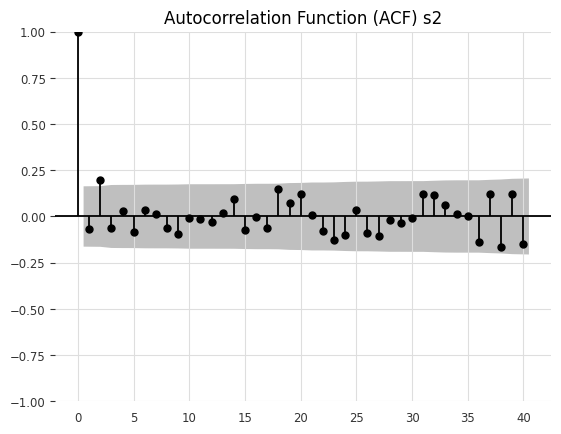

ADF Statistic: -7.0315
p-value: 0.0000
Stationary


In [72]:
# Cell 1: Import packages and generate a non-stationary series (trend)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# Cell 2: ACF plot and Augmented Dickey-Fuller (ADF) test
plot_acf(series, lags=40)
plt.title("Autocorrelation Function (ACF) s1")
plt.show()

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(series)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Stationary" if adf_result[1] < 0.05 else "Non-Stationary")

#now for the exp data
plot_acf(series2, lags=40)
plt.title("Autocorrelation Function (ACF) s2")
plt.show()

# Perform Augmented Dickey-Fuller test
adf_result2 = adfuller(series2)
print(f"ADF Statistic: {adf_result2[0]:.4f}")
print(f"p-value: {adf_result2[1]:.4f}")
print("Stationary" if adf_result2[1] < 0.05 else "Non-Stationary")



## 3) Time Series Decomposition

In [49]:
series.shape

(144, 1)

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Using known libs
def seasonal_decompose_dict(series, period=12):
    """
    Seasonal decomposition
    """
    decomposition = seasonal_decompose(series.to_numpy().reshape(-1), period = 12, model='multiplicative')
    return {
        'trend': decomposition.trend,
        'seasonal': decomposition.seasonal,
        'resid': decomposition.resid
    }

### Build your own version of a timeseries decomposition: x(t) = trend(t) + seasonal(t) + uncorrelated_noise_t

#### a) Define trend with moving average
#### b) Define seasonal by everaging pieces of timeseries of some period

In [51]:
# Using theoretical knowledge:
def my_seasonal_decompose(series : pd.Series, period=12, model='additive'):
    """
    Manual implementation of seasonal decomposition
    """
    numpy_series : np.ndarray = series.to_numpy().reshape(-1)
    trend = np.empty(numpy_series.shape[0])
    amount = 0
    for i in range(0, numpy_series.shape[0]):
        index = max(i-(2*period), 0)
        trend[i] = np.mean(numpy_series[index:i+1])
    detrended = numpy_series / trend
    seasonal = np.array([np.mean(np.array([ detrended[period*j + i] for j in range((trend.shape[0]-i) // period)])) for i in range(period)])
    seasonal = seasonal / (np.sum(seasonal)/period)
    seasonal = np.tile(seasonal,(trend.shape[0] // period) + 1)
    seasonal = seasonal[:trend.shape[0]]
    resid = detrended / seasonal
    return {
        'trend': pd.Series(trend, index=series.index),
        'seasonal': pd.Series(seasonal, index=series.index),
        'resid': pd.Series(resid, index=series.index)
    }

In [52]:
print(my_seasonal_decompose(series, 12))

{'trend': Month
1949-01-01    112.000000
1949-02-01    115.000000
1949-03-01    120.666667
1949-04-01    122.750000
1949-05-01    122.400000
                 ...    
1960-08-01    439.120000
1960-09-01    439.240000
1960-10-01    441.520000
1960-11-01    442.760000
1960-12-01    447.640000
Length: 144, dtype: float64, 'seasonal': Month
1949-01-01    0.916260
1949-02-01    0.901921
1949-03-01    1.026027
1949-04-01    0.985179
1949-05-01    0.983988
                ...   
1960-08-01    1.200557
1960-09-01    1.046803
1960-10-01    0.915695
1960-11-01    0.802865
1960-12-01    0.901940
Length: 144, dtype: float64, 'resid': Month
1949-01-01    1.091393
1949-02-01    1.137669
1949-03-01    1.066173
1949-04-01    1.066726
1949-05-01    1.004648
                ...   
1960-08-01    1.149494
1960-09-01    1.104833
1960-10-01    1.140249
1960-11-01    1.097119
1960-12-01    1.069984
Length: 144, dtype: float64}


## Key Differences between Our Implementation and models
### 1) Edge Handling: statsmodels uses more sophisticated edge handling for the moving average (even periods)
### 2) Seasonal Adjustment: statsmodels normalizes seasonal components more carefully (multiplicative models geometrically avereges to 1)
### 3) Performance: statsmodels uses optimized C code for the calculations

In [53]:
# Compare with statsmodels implementation

def compare_decompositions(series, period=30, model='additive'):
    # Our implementation
    ours = my_seasonal_decompose(series, period, model)
    
    # Statsmodels implementation
    sm_decomp = seasonal_decompose(series, period=period, model=model)
    
    # Plot comparisons
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    
    # Trend comparison
    axes[0,0].plot(ours['trend'], label='Our trend')
    axes[0,0].set_title('Our Trend')
    axes[0,1].plot(sm_decomp.trend, label='Statsmodels trend')
    axes[0,1].set_title('Statsmodels Trend')
    
    # Seasonal comparison
    axes[1,0].plot(ours['seasonal'], label='Our seasonal')
    axes[1,0].set_title('Our Seasonal')
    axes[1,1].plot(sm_decomp.seasonal, label='Statsmodels seasonal')
    axes[1,1].set_title('Statsmodels Seasonal')
    
    # Residual comparison
    axes[2,0].plot(ours['resid'], label='Our resid')
    axes[2,0].set_title('Our Residual')
    axes[2,1].plot(sm_decomp.resid, label='Statsmodels resid')
    axes[2,1].set_title('Statsmodels Residual')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate differences
    trend_diff = np.mean(np.abs(ours['trend'] - sm_decomp.trend))
    seasonal_diff = np.mean(np.abs(ours['seasonal'] - sm_decomp.seasonal))
    resid_diff = np.mean(np.abs(ours['resid'] - sm_decomp.resid))
    
    print(f"Trend component average difference: {trend_diff:.4f}")
    print(f"Seasonal component average difference: {seasonal_diff:.4f}")
    print(f"Residual component average difference: {resid_diff:.4f}")

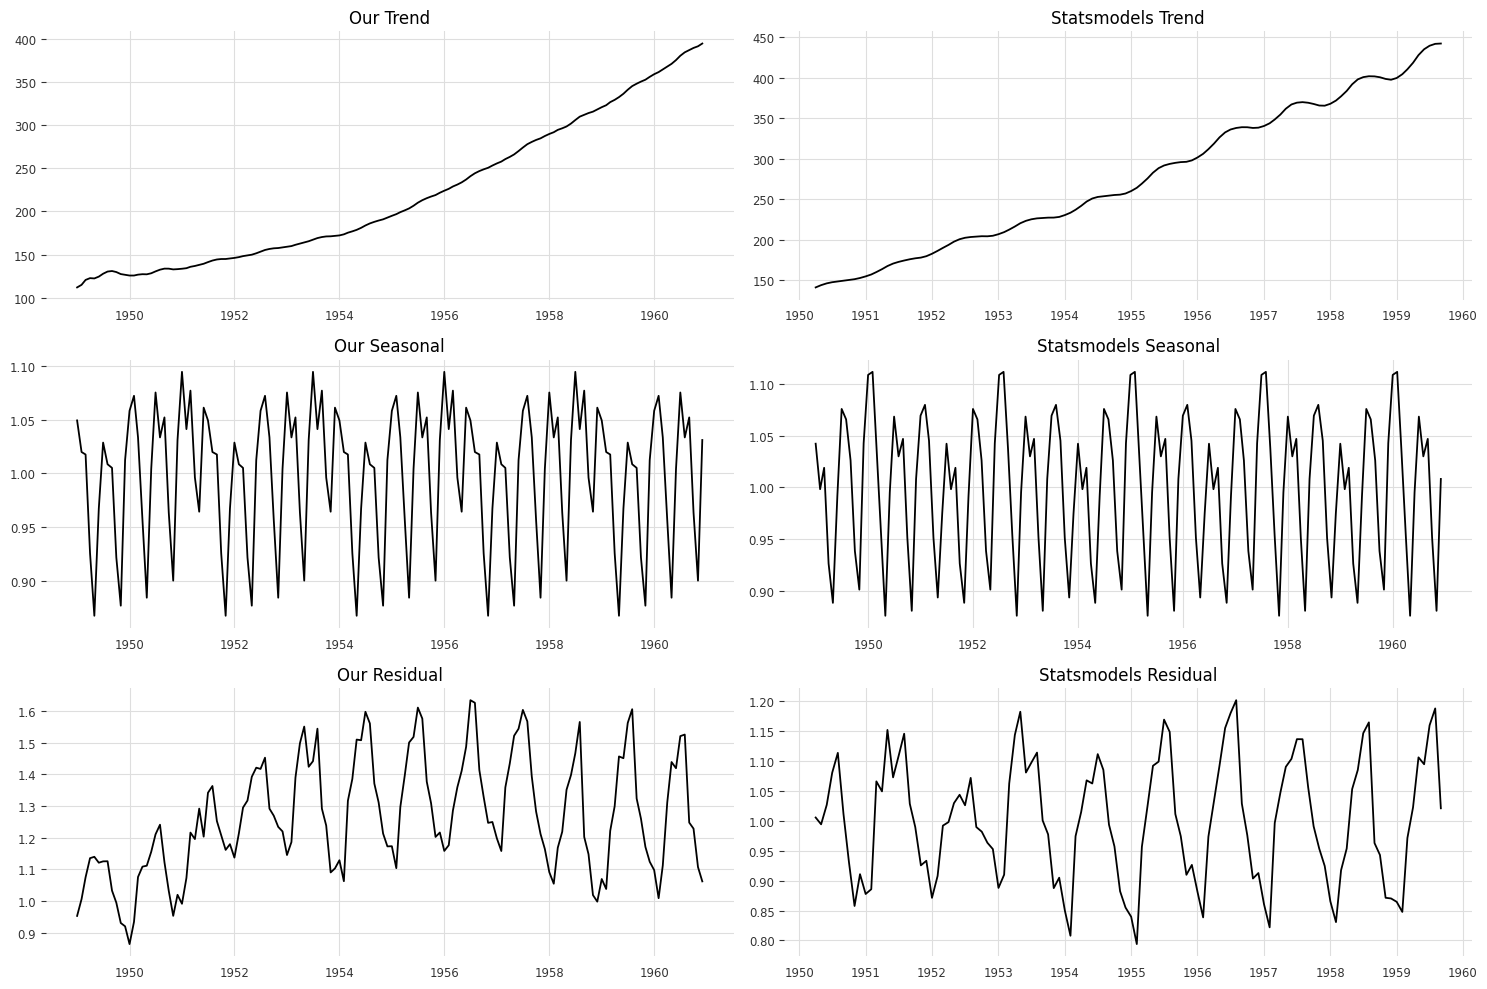

Trend component average difference: 64.4648
Seasonal component average difference: 0.0242
Residual component average difference: 0.2973


In [54]:
compare_decompositions(series, period=30, model='multiplicative')

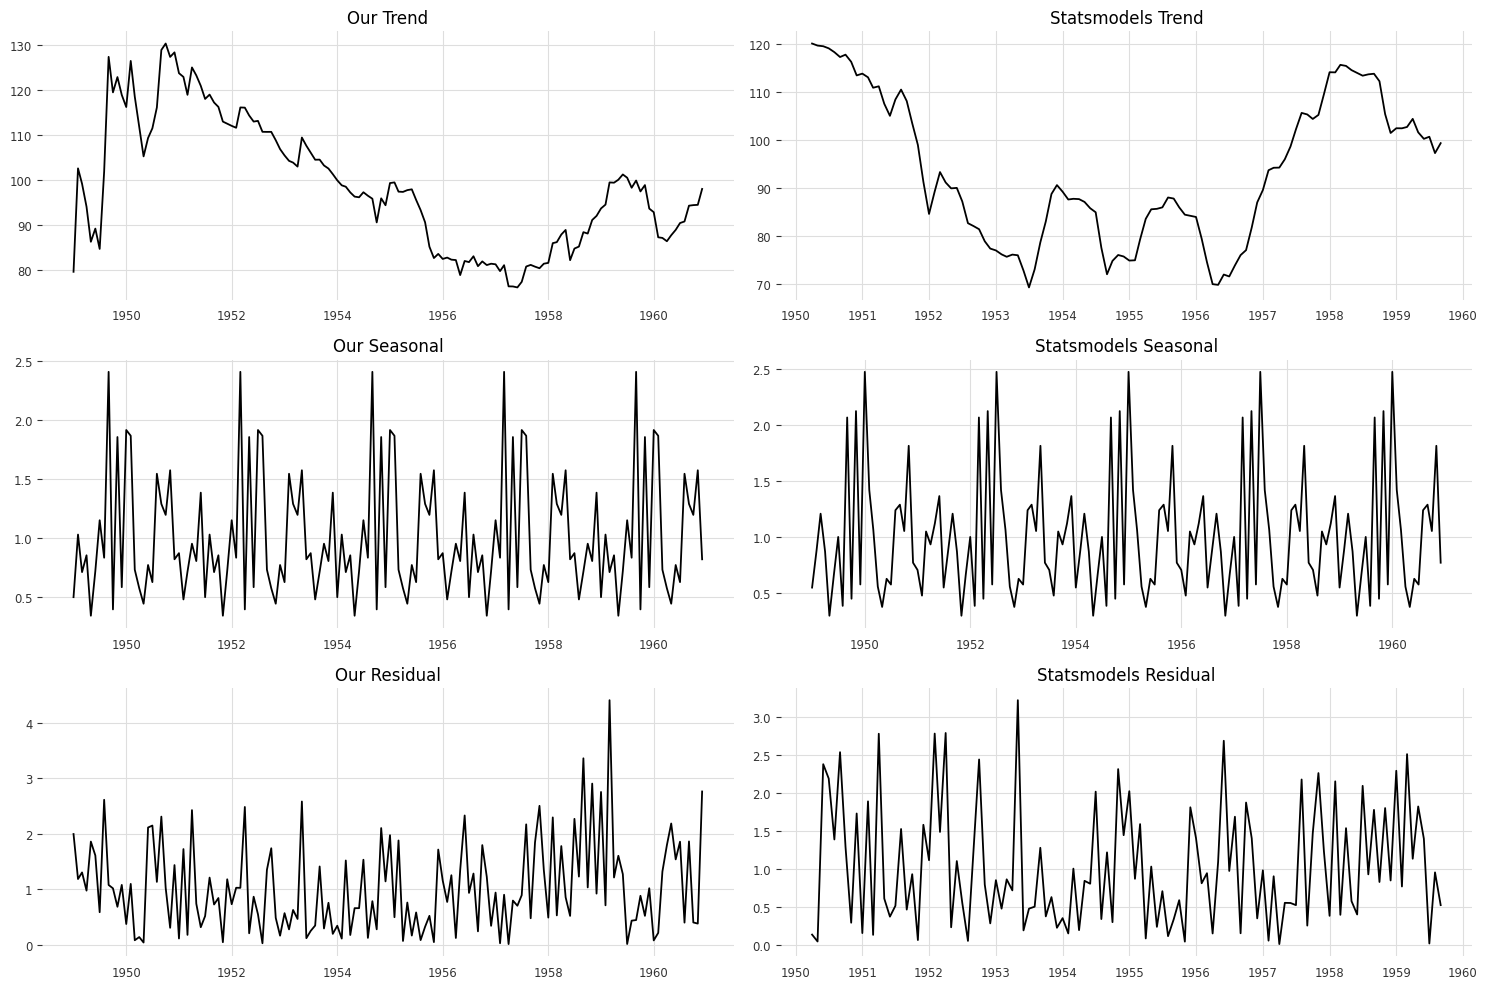

Trend component average difference: 16.0782
Seasonal component average difference: 0.1784
Residual component average difference: 0.2265


In [55]:
compare_decompositions(series2, period=30, model='multiplicative')

## 4) Darts is nice

### For stationarity analysis

ADF Test p-value: 0.9919
KPSS Test p-value: 0.0100
ADF Statistic: 0.8154
p-value: 0.9919
Non-Stationary


c:\Users\igors\AppData\Local\Programs\Python\Python312\Lib\site-packages\darts\utils\statistics.py:465: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  return kpss(ts.values(copy=False), regression, nlags)


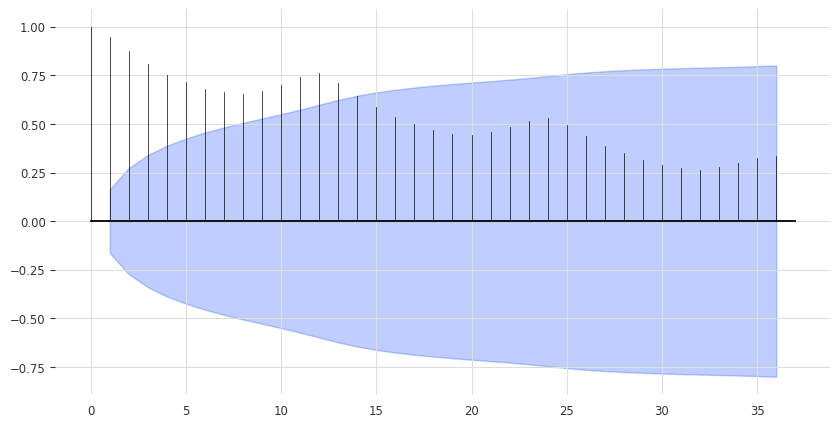

In [56]:
from darts import TimeSeries
from darts.utils.statistics import (
    stationarity_test_adf,  # Augmented Dickey-Fuller test
    stationarity_test_kpss,  # KPSS test
)
from darts.utils.statistics import plot_acf

series_darts = TimeSeries.from_csv('AirPassengers.csv', time_col='Month', value_cols=['#Passengers'])

# Visual inspection tools
#Confidence intervals (usually 95%): Horizontal dashed lines. If a bar crosses these lines, that lag is significantly autocorrelated.
plot_acf(series_darts, max_lag=36)  # Stationary series show rapid ACF decay

# Run ADF test (returns tuple: (test_statistic, pvalue, used_lag, n_obs, critical_values))
adf_result = stationarity_test_adf(series_darts)
print(f"ADF Test p-value: {adf_result[1]:.4f}")  # p-value < 0.05 suggests stationarity

# Run KPSS test
kpss_result = stationarity_test_kpss(series_darts)
print(f"KPSS Test p-value: {kpss_result[1]:.4f}")  # p-value > 0.05 suggests stationarity

# Perform Augmented Dickey-Fuller test
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Stationary" if adf_result[1] < 0.05 else "Non-Stationary")

### And decomposition

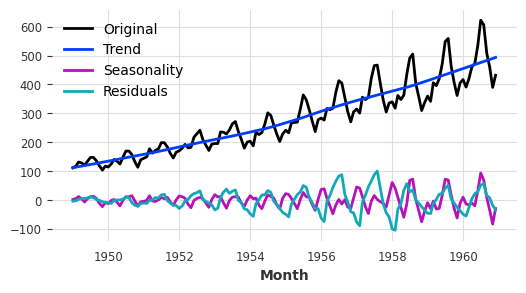

In [57]:
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode

# Perform decomposition (returns trend and seasonality)
trend, seasonality = extract_trend_and_seasonality(
    series_darts,
    model = ModelMode.ADDITIVE,
    freq=30,  # Set this to seasonal period
    #trend_width=5,  # Moving average window for trend (must be odd)
    #seasonal_width=11  # Window for seasonal smoothing (must be odd and < freq)
    method='STL'
)

# Calculate residuals manually
residuals = series_darts - trend - seasonality

# Plot results
plt.figure(figsize=(6, 3))
series_darts.plot(label='Original')
trend.plot(label='Trend')
seasonality.plot(label='Seasonality')
residuals.plot(label='Residuals')
plt.legend()
plt.show()

## 5) Forecasting Models

In [58]:
# Basic stupid model
def naive_forecast(train, horizon=12):
    """
    Naive forecasting (last value carried forward)
    """
    last_value = train[-1]
    return np.full(horizon, last_value)

# A simple exponential smoothing model (Does not include decomposition of trend and seasonality. Does not optimize alpha parameter)
def simple_exponential_smoothing(train, alpha=0.5, horizon=12):
    """
    Simple exponential smoothing
    """
    forecasts = []
    current = train[0]  # Initial value
    
    # Smooth the training data
    for value in train:
        current = alpha * value + (1 - alpha) * current
    
    # Forecast horizon steps ahead
    for _ in range(horizon):
        forecasts.append(current)
    
    return np.array(forecasts)

## Model Evaluation

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics(true_values, predicted_values):
    """
    Calculate evaluation metrics
    """
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

In [60]:
from darts.models import NaiveDrift, ExponentialSmoothing
from darts.metrics import mae, rmse, mape

def compare_exp_smoothing_with_darts(series, ts, horizon=12):
    """
    Compare our implementations with Darts
    """    
    train, test = ts.split_before(len(series)-horizon)
    
    # Naive forecast comparison
    our_naive = naive_forecast(train.values().flatten(), horizon)
    darts_naive = NaiveDrift().fit(train).predict(horizon).values().flatten()
    
    # Exponential smoothing comparison
    our_es = simple_exponential_smoothing(train.values().flatten(), horizon=horizon)
    darts_es = ExponentialSmoothing().fit(train).predict(horizon).values().flatten()
    
    # Compare metrics
    actuals = test.values().flatten()
    results = {
        'Naive': {
            'Our': calculate_metrics(actuals, our_naive),
        'Darts': {
            'MAE': mae(test, TimeSeries.from_times_and_values(test.time_index, darts_naive)),
            'RMSE': rmse(test, TimeSeries.from_times_and_values(test.time_index, darts_naive)),
            'MAPE': mape(test, TimeSeries.from_times_and_values(test.time_index, darts_naive))
        }

        },
        'Exponential Smoothing': {
            'Our': calculate_metrics(actuals, our_es),
            'Darts': {
                'MAE': mae(test, TimeSeries.from_times_and_values(test.time_index, darts_es)),
                'RMSE': rmse(test, TimeSeries.from_times_and_values(test.time_index, darts_es)),
                'MAPE': mape(test, TimeSeries.from_times_and_values(test.time_index, darts_es))
            }
        }
    }
    
    return results

compare_exp_smoothing_with_darts(series, series_darts, horizon=12)

{'Naive': {'Our': {'MAE': 76.0,
   'RMSE': np.float64(102.97653454387881),
   'MAPE': np.float64(14.251338486772209)},
  'Darts': {'MAE': np.float64(66.30788804071248),
   'RMSE': np.float64(92.66636342994124),
   'MAPE': np.float64(12.417957002111175)}},
 'Exponential Smoothing': {'Our': {'MAE': 75.54593925699346,
   'RMSE': np.float64(102.50701723853366),
   'MAPE': np.float64(14.163191291000748)},
  'Darts': {'MAE': np.float64(13.380462475074248),
   'RMSE': np.float64(16.979906128442913),
   'MAPE': np.float64(2.8028239476595274)}}}

## Write a simplified ARIMA forcasting algorithm (q=0) and compare with the Darts version

In [61]:
import statsmodels.api as sm
class MyARIMA:

    def __init__(self, original_series : pd.Series, p=1, d=1, q=0, steps=5):
        self.series = original_series.to_numpy().reshape(-1)
        self.p = p
        self.d = d
        self.q = q
        self.steps = steps
        self.AR_model = None

    def difference(self, series : np.ndarray, order=1):
        """Perform differencing of the series to make it stationary."""
        for i in range(order):
            series = series[1:] - series[0:series.shape[0]-1]
        print(series)
        return series

    def inverse_difference(original_series, forecast_diff):
        """Revert the differencing step."""
        return 

    # -------- AR Model Fitting Function --------
    def fit_ar_model(self, diff_series):
        """Fit AR(p) model using ordinary least squares."""
        n = len(diff_series)
        # Storing values of AR equation in a column
        X = diff_series[:n-self.p]
        X = np.reshape(X, (-1, 1))
        
        for k in range(1, self.p):
            temp = diff_series[k:n-self.p+k]
            temp = np.reshape(temp, (-1, 1))
            X = np.hstack((X, temp))
        # Stacking them next to each other
        y = diff_series[self.p:]
        self.noise = np.std(X)
        self.AR_model = sm.OLS(y, X).fit()
        print(self.AR_model.summary())
        print(self.AR_model.predict(X))
        return 

    # -------- Forecast Function --------
    def forecast_arima(self):
        """Forecast using simplified ARIMA(p,d,0) model."""
        diff_series = self.difference(self.series, self.d)
        self.fit_ar_model(diff_series)
        ans = np.empty(self.steps)
        needed = diff_series[-self.p:]
        for i in range(self.steps):
            next = self.AR_model.predict(np.reshape(needed, (1, -1))) + self.series[-1]
            self.series = np.concatenate([self.series, next])
            needed = np.roll(needed, -1)
            ans[i] = next
            needed[-1] = self.difference(self.series[-self.d-1:], self.d)
        return ans


[   6   14   -3   -8   14   13    0  -12  -17  -15   14   -3   11   15
   -6  -10   24   21    0  -12  -25  -19   26    5    5   28  -15    9
    6   21    0  -15  -22  -16   20    5    9   13  -12    2   35   12
   12  -33  -18  -19   22    2    0   40   -1   -6   14   21    8  -35
  -26  -31   21    3  -16   47   -8    7   30   38   -9  -34  -30  -26
   26   13   -9   34    2    1   45   49  -17  -35  -38  -37   41    6
   -7   40   -4    5   56   39   -8  -50  -49  -35   35    9  -14   55
   -8    7   67   43    2  -63  -57  -42   31    4  -22   44  -14   15
   72   56   14 -101  -45  -49   27   23  -18   64  -10   24   52   76
   11  -96  -56  -45   43   12  -26   28   42   11   63   87  -16  -98
  -47  -71   42]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.140
Model:                            OLS   Adj. R-squared (uncentered):              0.127
Method:  

C:\Users\igors\AppData\Local\Temp\ipykernel_21812\2564282410.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ans[i] = next
C:\Users\igors\AppData\Local\Temp\ipykernel_21812\2564282410.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  needed[-1] = self.difference(self.series[-self.d-1:], self.d)


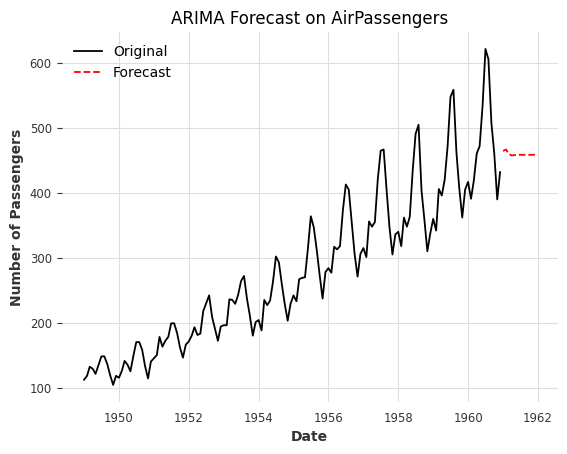

In [62]:
# Load the dataset
#series = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
series_squeezed = series.squeeze()  # convert DataFrame to Series if needed

# Forecast using ARIMA(p=2, d=1, q=0)
forecast_steps = 12
my_arima = MyARIMA(series_squeezed, p=2, d=1, q=0, steps=forecast_steps)
forecast = my_arima.forecast_arima()

# Plot original + forecast
plt.plot(series, label='Original')
forecast_index = pd.date_range(start=series.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
plt.plot(forecast_index, forecast, label='Forecast', linestyle='--', color='red')
plt.title("ARIMA Forecast on AirPassengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()


In [63]:
def compare_arima_with_darts(series, darts_series, perc_train, order=(1,1,1) ):
    """
    Compare our ARIMA with Darts implementation
    """
    from darts.models import ARIMA as DartsARIMA
    from darts.metrics import mae, rmse
    
    # Split data
    train_size = int(len(series) * perc_train)
    test_size = len(series)-train_size
    train, test = series[:train_size], series[train_size:]
    
    # Our implementation
    series_squeezed = series.squeeze()[:train_size]
    our_arima = MyARIMA(series_squeezed, p=order[0], d=order[1], q=0, steps=test_size)
    our_forecast = our_arima.forecast_arima()
    
    # Darts implementation
    #darts_series = TimeSeries.from_series(series)
    darts_train, darts_test = darts_series.split_before(train_size)
    
    darts_model = DartsARIMA(p=order[0], d=order[1], q=order[2])
    darts_model.fit(darts_train)
    darts_forecast = darts_model.predict(len(test))
    
    # Calculate metrics
    results = {
        'Our ARIMA': {
            'MAE': mean_absolute_error(test, our_forecast),
            'RMSE': np.sqrt(mean_squared_error(test, our_forecast))
        },
        'Darts ARIMA': {
            'MAE': mae(darts_test, darts_forecast),
            'RMSE': rmse(darts_test, darts_forecast)
        }
    }
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, our_forecast, label='Our ARIMA')
    plt.plot(test.index, darts_forecast.values().flatten(), label='Darts ARIMA')
    plt.title('ARIMA Forecast Comparison')
    plt.legend()
    plt.show()
    
    return results

[  6  14  -3  -8  14  13   0 -12 -17 -15  14  -3  11  15  -6 -10  24  21
   0 -12 -25 -19  26   5   5  28 -15   9   6  21   0 -15 -22 -16  20   5
   9  13 -12   2  35  12  12 -33 -18 -19  22   2   0  40  -1  -6  14  21
   8 -35 -26 -31  21   3 -16  47  -8   7  30  38  -9 -34 -30 -26  26  13
  -9  34   2   1  45  49 -17 -35 -38 -37  41   6  -7  40  -4   5  56  39
  -8 -50 -49 -35  35   9 -14  55  -8   7  67  43   2 -63 -57 -42  31   4
 -22  44 -14  15  72  56]
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.944
Model:                            OLS   Adj. R-squared (uncentered):              0.913
Method:                 Least Squares   F-statistic:                              30.28
Date:                Wed, 11 Jun 2025   Prob (F-statistic):                    2.70e-24
Time:                        12:15:25   Log-Likelihood:                         -284.21
No. Obse

C:\Users\igors\AppData\Local\Temp\ipykernel_21812\2564282410.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ans[i] = next
C:\Users\igors\AppData\Local\Temp\ipykernel_21812\2564282410.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  needed[-1] = self.difference(self.series[-self.d-1:], self.d)
c:\Users\igors\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\igors\AppData\Local\Programs\Python\Python312\Lib\si

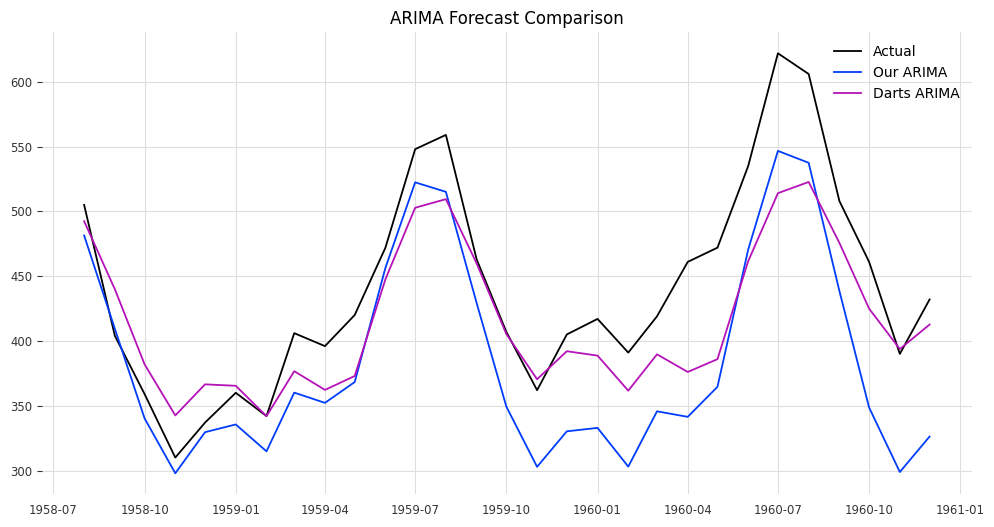

{'Our ARIMA': {'MAE': 56.20958360695795,
  'RMSE': np.float64(65.13713501460697)},
 'Darts ARIMA': {'MAE': np.float64(34.781783456771564),
  'RMSE': np.float64(44.47609712730393)}}

In [64]:
perc_train = 0.8
compare_arima_with_darts(series, series_darts,perc_train, order=(30,1,1) )

## Assignment:
### a) Find one ore more interesting timeseries to analyze. Check for stationarity and/or any possible statistical assumption.
### b) Try decomposition and comment any relevant result 
### c) Implement and explain (in your presentation) a forcasting method and it's performance. (The forecasting method does not have to be necessarily among the ones explained during classes)


## We chose simple traffic dataset available on kaggle

https://www.kaggle.com/datasets/fedesoriano/traffic-prediction-dataset

It contains 4 parameters:
1. DateTime - data when observation was measured (hourly)
2. Junction - junction where data was measured (there are 4 junctions, we will use only 1st one)
3. Vehicles - Amount of vehicles observed
4. ID - id of the object (unimportant, so we will drop it)

In [65]:
original_traffic = pd.read_csv("traffic.csv", parse_dates = ["DateTime"])
traffic = original_traffic.copy(deep = True)
traffic

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


#### We drop ID and select junction 1

In [66]:
traffic.drop(columns = "ID", inplace=True)
traffic.set_index("DateTime", inplace=True)

In [67]:
print(traffic["Junction"].value_counts())

Junction
1    14592
2    14592
3    14592
4     4344
Name: count, dtype: int64


In [68]:
# We will use only first junction (using multiple woulb be a bad idea)
traffic = traffic.loc[traffic['Junction'] == 1]['Vehicles']

C:\Users\igors\AppData\Local\Temp\ipykernel_21812\1460925267.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


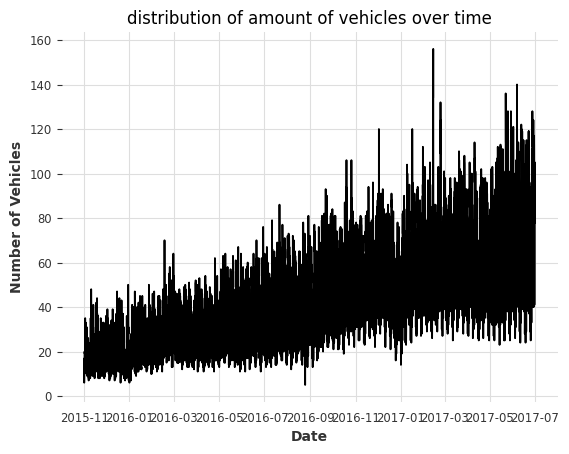

In [69]:
def plot_series(series):
    plt.plot(series)
    plt.title("distribution of amount of vehicles over time")
    plt.xlabel("Date")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()
plot_series(traffic)

Transform to darts timeseries, divide into train and test set

In [70]:
train_size = int(len(traffic) - 168)
test_size = len(traffic)-train_size
train, test = traffic[:train_size], traffic[train_size:]

traffic_darts = TimeSeries.from_times_and_values(times = traffic.index, values = traffic)
darts_train, darts_test = traffic_darts.split_before(train_size)

### Check stationarity

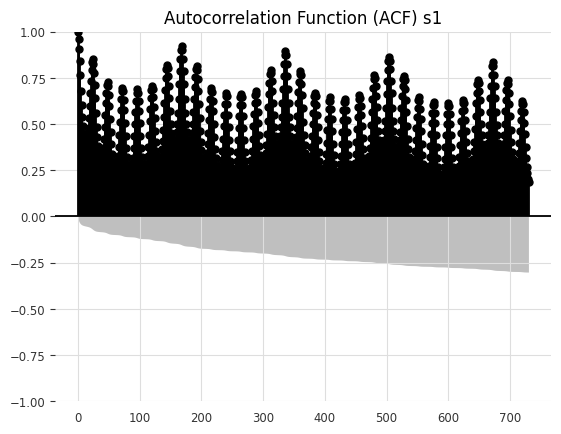

ADF Statistic: -7.1481
p-value: 0.0000
Stationary


In [81]:
# Cell 2: ACF plot and Augmented Dickey-Fuller (ADF) test
plot_acf(traffic, lags = 730)
plt.title("Autocorrelation Function (ACF) s1")
plt.show()

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(traffic)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Stationary" if adf_result[1] < 0.05 else "Non-Stationary")

#### Showing decomposition to trend, seasonality and residuals

In [74]:
def show_decompositions(series, period=730, model='additive'):
    decomp = seasonal_decompose(series, period=period, model=model)
    
    # Plot comparisons
    fig, axes = plt.subplots(3, 1, figsize=(7, 21))
    
    # Trend comparison
    axes[0].plot(decomp.trend, label='trend')
    axes[0].set_title('Trend')
    
    # Seasonal comparison
    axes[1].plot(decomp.seasonal, label='seasonality')
    axes[1].set_title('Seasonality')
    
    # Residual comparison
    axes[2].plot(decomp.resid, label='residuals')
    axes[2].set_title('Residuals')
    
    plt.tight_layout()
    plt.show()

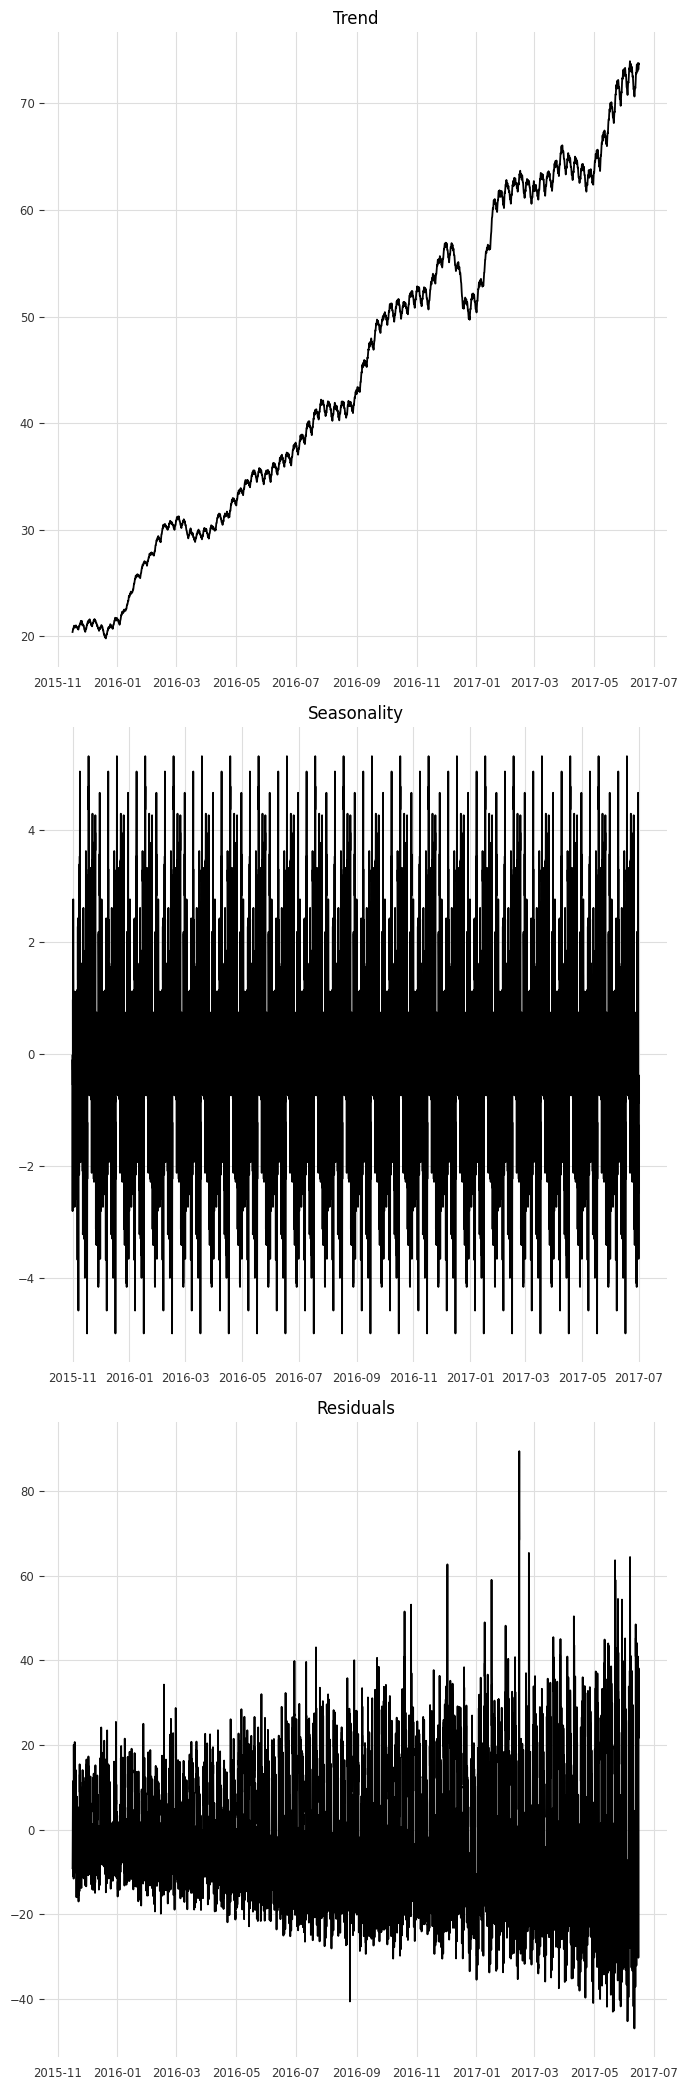

In [75]:
show_decompositions(traffic)

Sadly we cannot see a lot in seasonality; it is very unstable

## We will try to predict week of traffic based on previous data

Simple framework for fitting model and then depicting it's predictions it against real values

In [76]:
def Darts_model_prediction(predicting_model, name, **kwargs):

    
    # Darts implementation
    #darts_series = TimeSeries.from_series(series)
    darts_model = predicting_model(**kwargs)
    darts_model.fit(darts_train)
    darts_forecast = darts_model.predict(test_size)
    #return darts_model
    print(
            "Mean absolute error: ", mae(darts_test, darts_forecast), '\n',
            "Root Mean Squared Error: ", rmse(darts_test, darts_forecast), '\n',
            "Mean Absolute Percentage Error: ", mape(darts_test, darts_forecast)
    )
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, darts_forecast.values().flatten().astype(int), label='Our model')
    plt.title(f'{name} Forecast Comparison')
    plt.legend()
    plt.show()

First we will test simple ARIMA with 1 differencing, 24 past observations and 2 timeslot of moving average

c:\Users\igors\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error:  17.422125041137168 
 Root Mean Squared Error:  21.364704378465138 
 Mean Absolute Percentage Error:  22.667059131025113


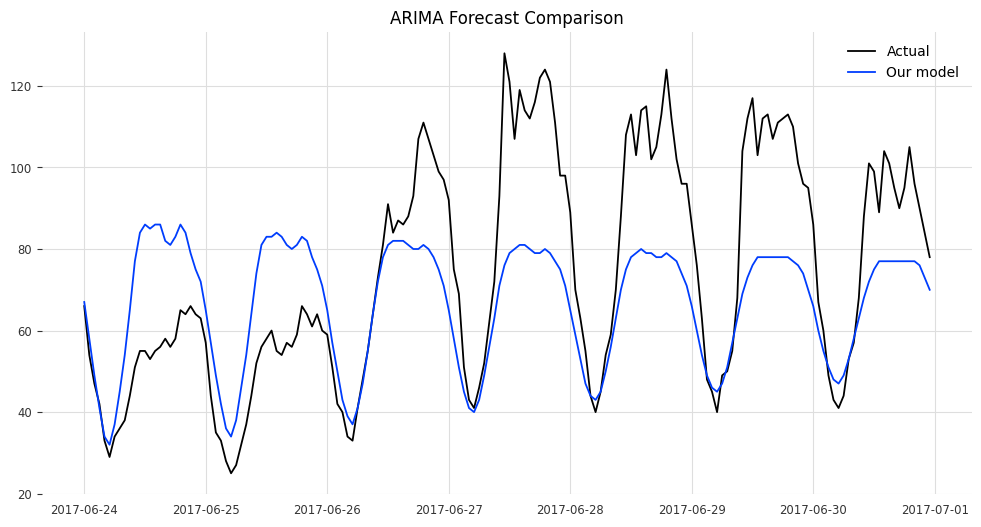

In [77]:
from darts.models import ARIMA as DartsARIMA
Darts_model_prediction(DartsARIMA, "ARIMA", p = 24, d = 1, q = 2)

Now time for forecast with XGBoost (it will use past 168 observations)
(XGBoost - extreme gradient boosting; popular ML method of prediction; here we use modified darts version to better tackle forecasting tasks)

Mean absolute error:  6.213928699493408 
 Root Mean Squared Error:  7.995679936731331 
 Mean Absolute Percentage Error:  8.37822887692553


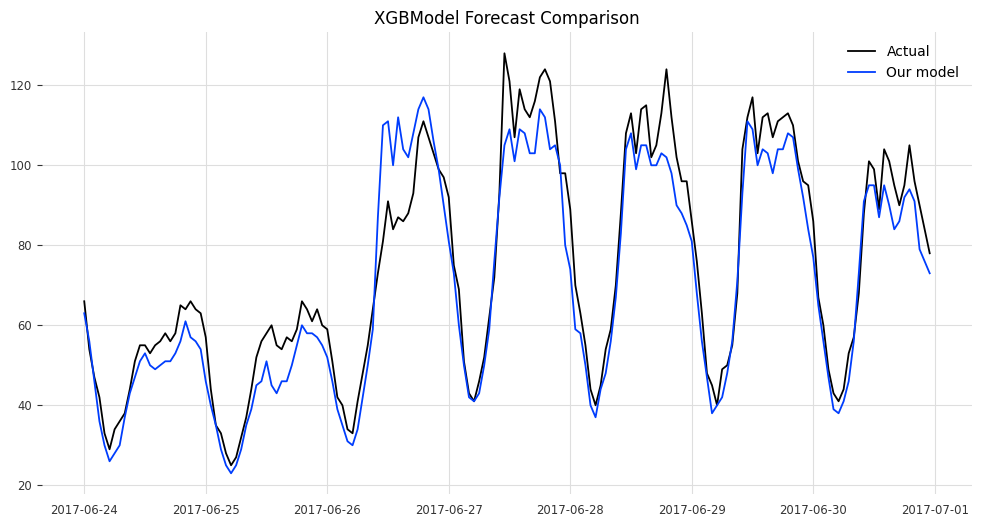

In [78]:
from darts.models import XGBModel
Darts_model_prediction(XGBModel, "XGBModel", lags = 168)

In [ ]:
print(test)

Mean absolute error:  4.8917891298021585 
 Root Mean Squared Error:  6.647985128991098 
 Mean Absolute Percentage Error:  6.764728184280072


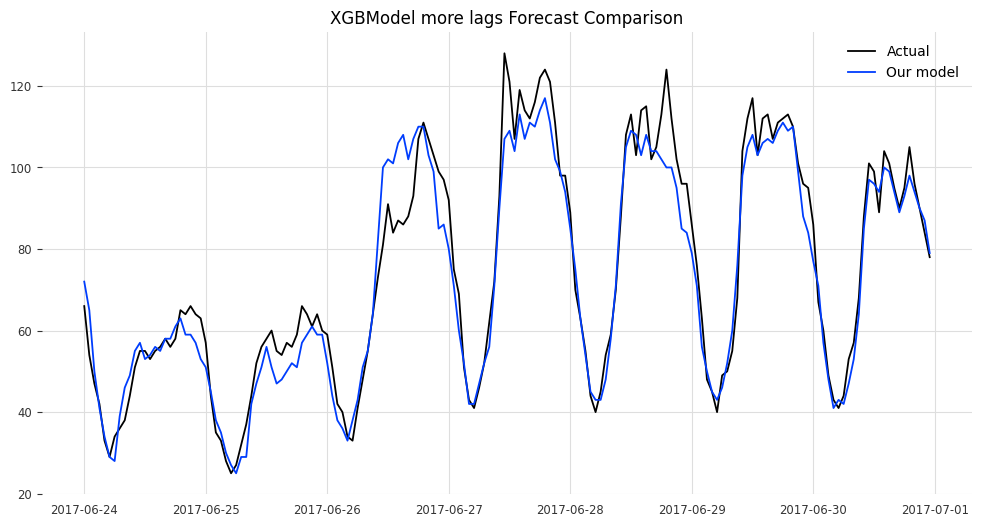

In [80]:
# optionally, use some future covariates; e.g. the value of the month encoded as a sine and cosine series
Darts_model_prediction(XGBModel, "XGBModel more lags", lags = 10000)

Finally, some testing of deep learning approach (using Recurrent neural networks)
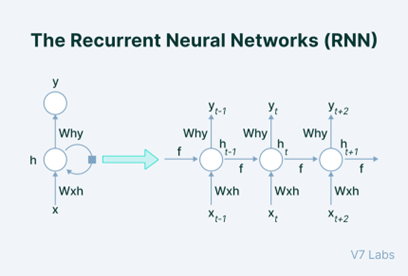

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
c:\Users\igors\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: '

Epoch 19: 100%|██████████| 891/891 [00:53<00:00, 16.80it/s, v_num=logs, train_loss=19.10] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 891/891 [00:53<00:00, 16.80it/s, v_num=logs, train_loss=19.10]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]
Mean absolute error:  21.89788672758461 
 Root Mean Squared Error:  25.799046384231094 
 Mean Absolute Percentage Error:  27.713548955479517


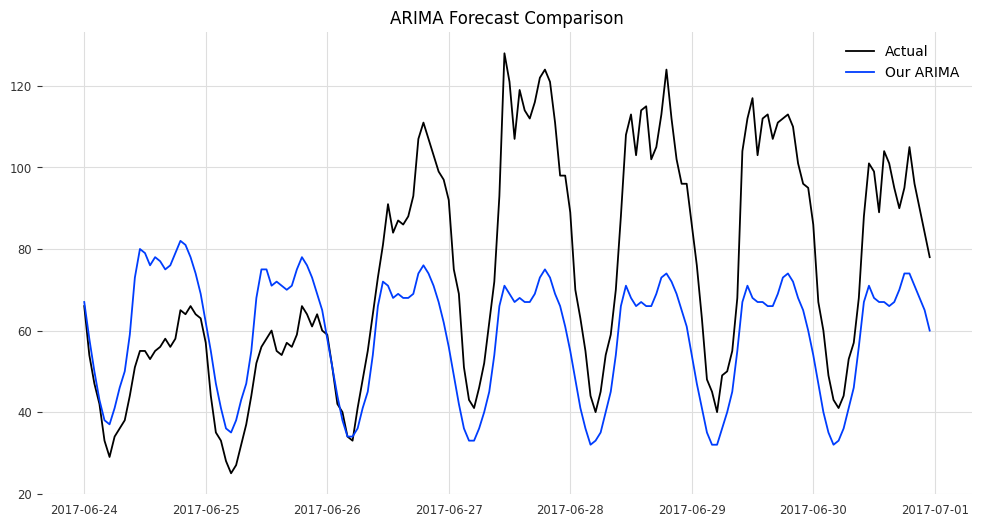

In [ ]:
from darts.models import RNNModel
Darts_model_prediction(RNNModel, model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=20,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Traffic_RNN",
    log_tensorboard=True,
    random_state=42,
    training_length=168,
    input_chunk_length=167,
    force_reset=True,
    save_checkpoints=True)